In [6]:

import ICE.Data
import ICE.ModelWrapper
import ICE.Explainer
import ICE.utils

import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from dataset_loader import CSVDatasetWithName
import torch
import numpy as np
import shutil
import os

from pathlib import Path

In [2]:
import pandas as pd
import numpy as np

In [3]:
###not to run
#images_path = '../data/HAM10000/ISIC2018_Task3_Training_Input/'
#csv_path = '../data/csv_splits/isic2018f_train.csv'
#model_path = '../models/iv4_isic2018_t3/checkpoints/model_best.pth'

In [4]:
#images_path = '../../isic-data/HAM10000/ISIC2018_Task3_Training_Input/'
images_path = '../../isic-data/ISIC2018_Task1-2_Training_Input/'
csv_path = 'isic2018_T1T2_results_complete.csv'
model_path = '../../DL-Models-ISIC/results-comet-iv4/iv4_i18nf_5runs_4/checkpoints/model_best.pth'

In [5]:
df=pd.read_csv(csv_path)
images =df.image.values
labels = df.Label_true.values

In [7]:
df

,image,Label_true,Label_pred_iv4,Prob_pred_iv4,Label_pred_rn50,Prob_pred_rn50
0,ISIC_0014795,1,0,0.948783,0,0.999844
1,ISIC_0015216,0,0,0.999198,0,0.884254
2,ISIC_0014931,1,1,0.566571,0,0.812529
3,ISIC_0015568,0,0,0.982696,0,0.999282
4,ISIC_0014792,0,0,0.987733,0,0.663082
...,...,...,...,...,...,...
2589,ISIC_0009860,0,0,0.998342,0,0.999897
2590,ISIC_0016072,0,0,0.971620,0,1.000000
2591,ISIC_0000999,0,0,0.999832,0,0.999128
2592,ISIC_0000882,0,0,0.999972,0,1.000000


In [8]:
df['image'] = df['image'].astype(str) +'.jpg'

In [9]:
id2label = {0:'Benign',1:'Melanoma'}

In [10]:
preprocess = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
idx=0
benign_df=df.loc[((df['Label_true']==idx) & (df['Label_pred_iv4']==idx) & (df['Label_pred_rn50']==idx))]
ben_df=benign_df.sample(n=78,random_state=0)
idx=1
mel_df=df.loc[((df['Label_true']==idx) & (df['Label_pred_iv4']==idx) & (df['Label_pred_rn50']==idx))]

final_df_list=[ben_df,mel_df]
final_df = pd.concat(final_df_list)
final_df = final_df.rename(columns={'Label_true': 'label'})
lala=final_df.image.values

In [12]:
lala

array(['ISIC_0002488.jpg', 'ISIC_0014581.jpg', 'ISIC_0013738.jpg',
       'ISIC_0000421.jpg', 'ISIC_0010588.jpg', 'ISIC_0000496.jpg',
       'ISIC_0000081.jpg', 'ISIC_0000352.jpg', 'ISIC_0000433.jpg',
       'ISIC_0016052.jpg', 'ISIC_0011373.jpg', 'ISIC_0001871.jpg',
       'ISIC_0012475.jpg', 'ISIC_0010562.jpg', 'ISIC_0014923.jpg',
       'ISIC_0013325.jpg', 'ISIC_0013238.jpg', 'ISIC_0015202.jpg',
       'ISIC_0014394.jpg', 'ISIC_0014453.jpg', 'ISIC_0010178.jpg',
       'ISIC_0015009.jpg', 'ISIC_0015985.jpg', 'ISIC_0012223.jpg',
       'ISIC_0013235.jpg', 'ISIC_0013094.jpg', 'ISIC_0015641.jpg',
       'ISIC_0000047.jpg', 'ISIC_0000486.jpg', 'ISIC_0000388.jpg',
       'ISIC_0015223.jpg', 'ISIC_0000189.jpg', 'ISIC_0002975.jpg',
       'ISIC_0014765.jpg', 'ISIC_0011328.jpg', 'ISIC_0015973.jpg',
       'ISIC_0000418.jpg', 'ISIC_0016046.jpg', 'ISIC_0012212.jpg',
       'ISIC_0004715.jpg', 'ISIC_0000357.jpg', 'ISIC_0002246.jpg',
       'ISIC_0000538.jpg', 'ISIC_0014992.jpg', 'ISIC_0012803.j

In [13]:


def make_imgs(paths = [],labels = []):
    imgs = []
    for i,path in enumerate(paths):
        imgs += [(os.path.join(images_path,path),labels[0])]
    
    return imgs

def get_loaders(df,target_classes = []):
    loaders = []
    for i,idx in enumerate(target_classes):
        loaders.append(DataLoader(
                ICE.Data.ImageDataset(make_imgs(df.loc[((df['label']==idx) & (df['Label_pred_iv4']==idx) & (df['Label_pred_rn50']==idx))]['image'],[idx]),
                      transform = preprocess),
                batch_size = 64,
                num_workers=1,))
    return loaders


def get_explainer(paras,model,df,high_res):
    classes_names = paras['classes_names']
    target_classes = paras['target_classes']
    n_components = paras['n_components']
    layer_name = paras['layer_name'] 
    title = paras['title']
    overwrite = paras['overwrite']

    if overwrite:
        try:
            shutil.rmtree('Explainers/'+title)
        except:
            pass

    model.set_predict_target(target_classes)
    loaders = get_loaders(df,target_classes)
    if os.path.exists(Path('Explainers')/title):
        Exp = ICE.Explainer.Explainer(title = title)
        Exp.load()
        print ('model loaded')
    else:

    # create an Explainer
        Exp = ICE.Explainer.Explainer(title = title,
                        layer_name = layer_name,
                        class_names = classes_names,
                        utils = ICE.utils.img_utils(mode = "torch"),
                        n_components = n_components,
                        reducer_type = "NMF", 
                        high_res=high_res
                      )

        # train reducer based on target classes
        Exp.train_model(model,loaders)
        # generate features 
        Exp.generate_features(model, loaders)
        # generate global explanations
        Exp.global_explanations()
        # save the explainer, use load to load it with the same title
        Exp.save()

    return Exp

m = torch.load(model_path)
m = m.cuda()
m.eval()


InceptionV4(
  (features): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Mixed_3a(
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): BasicConv2d(
        (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, mo

## Test with 12 to 16 components

In [12]:
from IPython.display import display, Image

n_components_array=[10]

paras = {}
paras['target_classes'] = [0,1]
paras['classes_names'] = ['benign','melanoma']
paras['n_components'] = 12
paras['layer_name'] = 'features'
paras['title'] = "new_viz__12_concepts_t1t2"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=128,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)

Explainers_list=[]

for nc in range(12,17):
    paras['n_components'] = nc
    paras['title'] = "hr_78b_skin2class_concepts_"+str(nc)
    print('\n------\n')
    for k,v in paras.items():
      print (k,':',v)
    Exp = get_explainer(paras,model,final_df,high_res=True)
    Explainers_list.append(Exp)

for expl in Explainers_list:
    print('Number of componensts:  {}, fidelity error: {}, average : {}'.format(expl.n_components, expl.reducer_err,expl.reducer_err.mean()))
    


------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 12
layer_name : features
title : hr_78b_skin2class_concepts_12
overwrite : True
Training reducer:
1/5 Featuer maps gathered.
loading complete, with size of (156, 8, 8, 1536)


/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


2/5 Reducer trained, spent 12.248412132263184 s.
3/5 Error estimated, fidelity: [0.1115387 0.1295075].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([ 2, 22,  0, 39, 32]), array([ 81, 145, 108,  89, 137]), array([44,  9, 16, 70, 20]), array([54,  6, 14, 17, 25]), array([59,  5, 57, 34,  8]), array([ 7, 41, 28, 42, 27]), array([106, 101, 149, 100, 141]), array([52, 31, 13, 35, 21]), array([154, 127, 130, 112, 123]), array([ 4, 56, 19, 46, 44]), array([35, 15, 48, 50,  1]), array([ 97, 128,  90,  99, 119])]
Generate explanations with fullset condition

------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 13
layer_name : features
title : hr_78b_skin2class_concepts_13
overwrite : True
Training reducer:
1/5 Featuer maps gathered.
loading complete, 

/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


2/5 Reducer trained, spent 3.6692707538604736 s.
3/5 Error estimated, fidelity: [0.10530067 0.12847153].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([ 2, 22,  0, 39, 32]), array([142, 108,  81,  89, 137]), array([44,  9, 16, 70, 20]), array([53,  6, 14, 17, 25]), array([59,  5, 34, 57,  8]), array([ 7, 41, 28, 42, 27]), array([106, 101, 149, 100, 141]), array([48, 13, 31, 35, 21]), array([154, 127, 130, 112, 123]), array([23, 56, 19, 46, 44]), array([35, 15, 48, 50,  1]), array([ 97, 128,  90,  99, 119]), array([134, 132, 140,  78, 121])]
Generate explanations with fullset condition

------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 14
layer_name : features
title : hr_78b_skin2class_concepts_14
overwrite : True
Training reducer:
1

/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2/5 Reducer trained, spent 10.613430976867676 s.
3/5 Error estimated, fidelity: [0.10482568 0.13008351].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([ 2, 22,  0, 39, 32]), array([ 91, 108,  81,  89, 137]), array([44,  9, 16, 70, 20]), array([ 6, 53, 14, 17, 25]), array([59, 34,  5, 57,  8]), array([ 7, 41, 28, 42, 27]), array([106, 101, 149, 100, 141]), array([35, 15, 50, 48,  1]), array([148, 143, 127, 123, 112]), array([142, 102, 103, 130, 151]), array([23, 46, 56, 19, 44]), array([114, 128,  90,  99, 119]), array([140, 132, 134, 121, 145]), array([38, 13, 31, 35, 21])]
Generate explanations with fullset condition

------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 15
layer_name : features
title : hr_78b_skin2class_concep

/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2/5 Reducer trained, spent 9.518365621566772 s.
3/5 Error estimated, fidelity: [0.10268491 0.12640267].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([22,  2,  0, 39, 32]), array([108, 142,  81,  89, 137]), array([44,  9, 16, 70, 20]), array([ 6, 53, 14, 17, 25]), array([104,  87, 132, 134, 145]), array([40, 41, 28, 42, 27]), array([106, 101, 149, 100, 141]), array([26, 13, 31, 35, 21]), array([123, 154, 124, 148, 130]), array([23, 19, 56, 46, 44]), array([35, 15, 48, 50,  1]), array([ 97, 128,  90,  99, 119]), array([112,  83,  78, 122, 143]), array([59, 34,  5, 57,  8]), array([ 4, 47, 22, 14,  3])]
Generate explanations with fullset condition

------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 16
layer_name : featu

/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2/5 Reducer trained, spent 15.706502914428711 s.
3/5 Error estimated, fidelity: [0.10251348 0.13413463].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([22,  2,  0, 39, 32]), array([129, 108,  89,  81, 137]), array([44,  9, 16, 70, 20]), array([54, 53, 14, 17, 25]), array([59, 34,  5, 57,  8]), array([ 7, 41, 28, 42, 27]), array([106, 101, 149, 100, 141]), array([13, 48, 31, 35, 21]), array([143, 154, 127, 123, 112]), array([142, 102, 103, 130, 151]), array([35, 15, 48, 50,  1]), array([128, 114,  90,  99, 119]), array([132, 140, 134, 121, 145]), array([23, 46, 19, 56, 44]), array([24, 47, 22, 14,  3]), array([43, 13, 40, 58, 62])]
Generate explanations with fullset condition
Number of componensts:  12, fidelity error: [0.1115387 0.1295075], ave

## -

In [14]:
Exp.feat_samples_index_list 

NameError: name 'Exp' is not defined

In [68]:
size_high_res=(2048,1536)
feature_path = Exp.exp_location / Exp.title / "feature_imgs"

img_size = [Exp.size_high_res[1], Exp.size_high_res[0],3]


In [71]:
str(feature_path)

'Explainers/hr_78b_skin2class_concepts_16/feature_imgs'

In [81]:
from PIL import Image
size_high_res=(2048,1536)
feature_path = Exp.exp_location / Exp.title / "feature_imgs/"

def get_attr_imgs_row(Exp,idx):
    idx_list =Exp.feat_samples_index_list[idx]
    x_list=[]
    for i in idx_list:
        img = Image.open(Exp.masked_imgs_path+Exp.class_images_names[i][:-4]+'_attributes.jpg')
        img=img.resize(size_high_res)
        x_list.append(img)
        
    x_list = np.hstack(x_list)
    imgs_comb = Image.fromarray(x_list)
    imgs_comb.save(feature_path+'c'+idx+'.jpg' )
    

In [82]:
get_attr_imgs_row(Exp.feat_samples_index_list[0])


In [64]:
tuple(x_imns)

(<PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F4C8F6ADE80>,
 <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F4C8F2081C0>,
 <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F4C8F201E20>,
 <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F4C8F201F40>,
 <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F4C8F201580>)

In [66]:
merged=Image.merge("RGB",tuple(x_imns))

TypeError: merge() missing 1 required positional argument: 'bands'

In [46]:
la=np.array([[1,2],[3,4],[5,6]])

In [52]:
xx=np.reshape(np.array(x_imns),(1536,10240,3))

In [53]:
np.array(x_imns).shape

(5, 1536, 2048, 3)

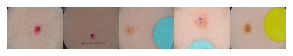

In [67]:

import matplotlib.pyplot as plt

ncols,nrows=1,1

plt.figure(figsize=(5*ncols, 5*nrows))
plt.subplot(nrows, ncols, 1)
plt.axis('off')
img = np.hstack(x_imns)
#img = np.clip(img,0,1)
plt.imshow(img)#,cmap = cmap)
    
                

## 16 components

In [14]:
from IPython.display import display, Image

n_components_array=[10]

paras = {}
paras['target_classes'] = [0,1]
paras['classes_names'] = ['benign','melanoma']
paras['n_components'] = 16
paras['layer_name'] = 'features'
paras['title'] = "test_iv4_16_concepts_t1t2"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=64,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)

Explainers_list=[]

for nc in range(16,17):
    paras['n_components'] = nc
    paras['title'] = "test_hr_78b_skin2class_concepts_64batchmodel"+str(nc)
    print('\n------\n')
    for k,v in paras.items():
      print (k,':',v)
    Exp_hr = get_explainer(paras,model,final_df,high_res=True)
    Explainers_list.append(Exp_hr)

for expl in Explainers_list:
    print('Number of componensts:  {}, fidelity error: {}, average : {}'.format(expl.n_components, expl.reducer_err,expl.reducer_err.mean()))


------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 16
layer_name : features
title : test_hr_78b_skin2class_concepts_64batchmodel16
overwrite : True
Training reducer:
1/5 Featuer maps gathered.
loading complete, with size of (156, 8, 8, 1536)


/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2/5 Reducer trained, spent 24.838594436645508 s.
3/5 Error estimated, fidelity: [0.10251348 0.13413463].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([22,  2,  0, 39, 32]), array([129, 108,  89,  81, 137]), array([44,  9, 16, 70, 20]), array([54, 53, 14, 17, 25]), array([59, 34,  5, 57,  8]), array([ 7, 41, 28, 42, 27]), array([106, 101, 149, 100, 141]), array([13, 48, 31, 35, 21]), array([143, 154, 127, 123, 112]), array([142, 102, 103, 130, 151]), array([35, 15, 48, 50,  1]), array([128, 114,  90,  99, 119]), array([132, 140, 134, 121, 145]), array([23, 46, 19, 56, 44]), array([24, 47, 22, 14,  3]), array([43, 13, 40, 58, 62])]
Generate explanations with fullset condition
Number of componensts:  16, fidelity error: [0.10251348 0.13413463], a

In [18]:
from PIL import Image
size_high_res=(2048,1536)


def get_attr_imgs_row(Exp,idx):
    feature_path = Exp.exp_location / Exp.title / "feature_imgs/"
    idx_list =Exp.feat_samples_index_list[idx]
    x_list=[]
    for i in idx_list:
        img = Image.open(Exp.masked_imgs_path+Exp.class_images_names[i][:-4]+'_attributes.jpg')
        img=img.resize(size_high_res)
        x_list.append(img)
        
    x_list = np.hstack(x_list)
    imgs_comb = Image.fromarray(x_list)
    imgs_comb.save(str(feature_path)+'c'+str(idx)+'.jpg' )
    
for i in range(0,16):
    get_attr_imgs_row(Exp_hr,i)

In [14]:
from IPython.display import display, Image

n_components_array=[10]

paras = {}
paras['target_classes'] = [0,1]
paras['classes_names'] = ['benign','melanoma']
paras['n_components'] = 12
paras['layer_name'] = 'features'
paras['title'] = "new_viz__12_concepts_t1t2"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=64,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)

Explainers_list=[]

for nc in range(16,17):
    paras['n_components'] = nc
    paras['title'] = "lr_78b_skin2class_concepts_64batch_model"+str(nc)
    print('\n------\n')
    for k,v in paras.items():
      print (k,':',v)
    Exp = get_explainer(paras,model,final_df,high_res=False)
    Explainers_list.append(Exp)

for expl in Explainers_list:
    print('Number of componensts:  {}, fidelity error: {}, average : {}'.format(expl.n_components, expl.reducer_err,expl.reducer_err.mean()))
    


------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 16
layer_name : features
title : lr_78b_skin2class_concepts_64batch_model16
overwrite : True
Training reducer:
1/5 Featuer maps gathered.
loading complete, with size of (156, 8, 8, 1536)


/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2/5 Reducer trained, spent 13.201639413833618 s.
3/5 Error estimated, fidelity: [0.10251348 0.13413463].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([22,  2,  0, 39, 32]), array([129, 108,  89,  81, 137]), array([44,  9, 16, 70, 20]), array([54, 53, 14, 17, 25]), array([59, 34,  5, 57,  8]), array([ 7, 41, 28, 42, 27]), array([106, 101, 149, 100, 141]), array([13, 48, 31, 35, 21]), array([143, 154, 127, 123, 112]), array([142, 102, 103, 130, 151]), array([35, 15, 48, 50,  1]), array([128, 114,  90,  99, 119]), array([132, 140, 134, 121, 145]), array([23, 46, 19, 56, 44]), array([24, 47, 22, 14,  3]), array([43, 13, 40, 58, 62])]
Generate explanations with fullset condition
Number of componensts:  16, fidelity error: [0.10251348 0.13413463], a

## Local explanations

(299, 299, 3)


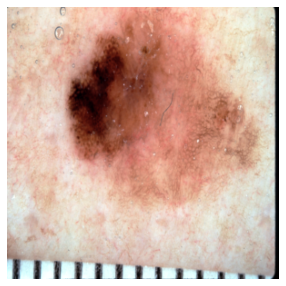

In [28]:
from PIL import Image
u1 = ICE.utils.img_utils(mode = "torch")
img_path = '../../isic-data/ISIC2018_Task1-2_Training_Input/ISIC_0014922.jpg'
img = Image.open(img_path)
x = transforms.ToTensor()(transforms.Resize((299,299))(img))
x = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(x).numpy()

x = np.transpose(x,(1,2,0)) #to channel_last
print (x.shape)

'''
#We skip this line since that we did not really train the explainer.
Exp.local_explanations(x,model)
'''

u1.show_img([x])

In [29]:
Exp.local_explanations(x,model,name='ISIC_0014922')

Prediction [-1.0608172   0.92359686]
Local feat_idx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


/code/share/ice/ICE/utils.py:226: UserWarning: No contour levels were found within the data range.
  ax.contour(X, Y, h,colors = 'r')


In [33]:
mel_df.image.values

array(['ISIC_0014982.jpg', 'ISIC_0014983.jpg', 'ISIC_0015284.jpg',
       'ISIC_0015132.jpg', 'ISIC_0014922.jpg', 'ISIC_0014666.jpg',
       'ISIC_0015229.jpg', 'ISIC_0015041.jpg', 'ISIC_0014946.jpg',
       'ISIC_0014826.jpg', 'ISIC_0014891.jpg', 'ISIC_0014784.jpg',
       'ISIC_0015071.jpg', 'ISIC_0015166.jpg', 'ISIC_0015110.jpg',
       'ISIC_0015243.jpg', 'ISIC_0015136.jpg', 'ISIC_0015190.jpg',
       'ISIC_0014932.jpg', 'ISIC_0014963.jpg', 'ISIC_0014857.jpg',
       'ISIC_0011135.jpg', 'ISIC_0010029.jpg', 'ISIC_0010231.jpg',
       'ISIC_0011112.jpg', 'ISIC_0010175.jpg', 'ISIC_0011348.jpg',
       'ISIC_0011158.jpg', 'ISIC_0010267.jpg', 'ISIC_0011099.jpg',
       'ISIC_0010235.jpg', 'ISIC_0010023.jpg', 'ISIC_0011121.jpg',
       'ISIC_0012290.jpg', 'ISIC_0014173.jpg', 'ISIC_0012749.jpg',
       'ISIC_0013473.jpg', 'ISIC_0013427.jpg', 'ISIC_0014558.jpg',
       'ISIC_0013594.jpg', 'ISIC_0000390.jpg', 'ISIC_0000293.jpg',
       'ISIC_0000169.jpg', 'ISIC_0000049.jpg', 'ISIC_0000031.j

In [39]:
for imag in mel_df.image.values:
    print(imag)
    img_path = '/code/isic-data/ISIC2018_Task1-2_Training_Input/'+ imag
    img = Image.open(img_path)
    x = transforms.ToTensor()(transforms.Resize((299,299))(img))
    x = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(x).numpy()

    x = np.transpose(x,(1,2,0))
    Exp.local_explanations(x,model,name=imag[:-4])

ISIC_0014982.jpg


AttributeError: type object 'Image' has no attribute 'open'

In [40]:
from PIL import Image
imag_array = ['ISIC_0010175.jpg','ISIC_0014946.jpg']
for imag in imag_array:
    img_path = '/code/isic-data/ISIC2018_Task1-2_Training_Input/'+ imag
    img = Image.open(img_path)
    x = transforms.ToTensor()(transforms.Resize((299,299))(img))
    x = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(x).numpy()

    x = np.transpose(x,(1,2,0))
    Exp_hr.local_explanations(x,model,name=imag[:-4])

Prediction [-0.51276094  0.75272   ]
Local feat_idx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Prediction [-2.7144542  2.5991416]
Local feat_idx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


/code/share/ice/ICE/utils.py:226: UserWarning: No contour levels were found within the data range.
  ax.contour(X, Y, h,colors = 'r')


In [46]:
# False positive
from PIL import Image
imag_array = ['ISIC_0012773.jpg']
for imag in imag_array:
    img_path = '/code/isic-data/ISIC2018_Task1-2_Training_Input/'+ imag
    img = Image.open(img_path)
    x = transforms.ToTensor()(transforms.Resize((299,299))(img))
    x = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(x).numpy()

    x = np.transpose(x,(1,2,0))
    Exp_hr.local_explanations(x,model,name=imag[:-4])

Prediction [-2.6932356  2.6329653]
Local feat_idx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [49]:
#False \negative ISIC_0012298
from PIL import Image
imag_array = ['ISIC_0012298.jpg']
for imag in imag_array:
    img_path = '/code/isic-data/ISIC2018_Task1-2_Training_Input/'+ imag
    img = Image.open(img_path)
    x = transforms.ToTensor()(transforms.Resize((299,299))(img))
    x = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(x).numpy()

    x = np.transpose(x,(1,2,0))
    Exp.local_explanations(x,model,name=imag[:-4])

Prediction [ 4.3804536 -4.284247 ]
Local feat_idx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [56]:
#False \negative ISIC_0011356, ISIC_0000030, ISIC_0000292,ISIC_0000288, ISIC_0015109 PAARA COMPARAR CON A RESNET
from PIL import Image
imag_array = ['ISIC_0015109.jpg']
for imag in imag_array:
    img_path = '/code/isic-data/ISIC2018_Task1-2_Training_Input/'+ imag
    img = Image.open(img_path)
    x = transforms.ToTensor()(transforms.Resize((299,299))(img))
    x = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(x).numpy()

    x = np.transpose(x,(1,2,0))
    Exp.local_explanations(x,model,name=imag[:-4])

Prediction [ 0.6640918  -0.79311186]
Local feat_idx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [57]:
from PIL import Image
imag_array = ['ISIC_0015109.jpg']
for imag in imag_array:
    img_path = '/code/isic-data/ISIC2018_Task1-2_Training_Input/'+ imag
    img = Image.open(img_path)
    x = transforms.ToTensor()(transforms.Resize((299,299))(img))
    x = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(x).numpy()

    x = np.transpose(x,(1,2,0))
    Exp_hr.local_explanations(x,model,name=imag[:-4])

Prediction [ 0.6640918  -0.79311186]
Local feat_idx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


## Other experiments with different number of components


In [ ]:
from IPython.display import display, Image

n_components_array=[10]

paras = {}
paras['target_classes'] = [0,1]
paras['classes_names'] = ['benign','melanoma']
paras['n_components'] = 12
paras['layer_name'] = 'features'
paras['title'] = "new_viz__12_concepts_t1t2"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=128,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)

Explainers_list=[]

for nc in range(12,17):
    paras['n_components'] = nc
    paras['title'] = "hr_78b_skin2class_concepts_"+str(nc)
    print('\n------\n')
    for k,v in paras.items():
      print (k,':',v)
    Exp = get_explainer(paras,model,final_df,high_res=True)
    Explainers_list.append(Exp)

for expl in Explainers_list:
    print('Number of componensts:  {}, fidelity error: {}, average : {}'.format(expl.n_components, expl.reducer_err,expl.reducer_err.mean()))
    

In [12]:
from IPython.display import display, Image

n_components_array=[10]

paras = {}
paras['target_classes'] = [0,1]
paras['classes_names'] = ['benign','melanoma']
paras['n_components'] = 12
paras['layer_name'] = 'features'
paras['title'] = "new_viz__12_concepts_t1t2"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=128,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)

Explainers_list=[]

for nc in range(12,17):
    paras['n_components'] = nc
    paras['title'] = "hr_78b_skin2class_concepts_"+str(nc)
    print('\n------\n')
    for k,v in paras.items():
      print (k,':',v)
    Exp = get_explainer(paras,model,final_df,high_res=True)
    Explainers_list.append(Exp)

for expl in Explainers_list:
    print('Number of componensts:  {}, fidelity error: {}, average : {}'.format(expl.n_components, expl.reducer_err,expl.reducer_err.mean()))
    


------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 12
layer_name : features
title : hr_78b_skin2class_concepts_12
overwrite : True
Training reducer:
1/5 Featuer maps gathered.
loading complete, with size of (156, 8, 8, 1536)


/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


2/5 Reducer trained, spent 11.252693891525269 s.
3/5 Error estimated, fidelity: [0.11154057 0.12950833].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([ 2, 22,  0, 39, 32]), array([ 81, 145, 108,  89, 137]), array([44,  9, 16, 70, 20]), array([54,  6, 14, 17, 25]), array([59,  5, 57, 34,  8]), array([ 7, 41, 28, 42, 27]), array([106, 101, 149, 100, 141]), array([52, 31, 13, 35, 21]), array([154, 127, 130, 112, 123]), array([ 4, 56, 19, 46, 44]), array([35, 15, 48, 50,  1]), array([ 97, 128,  90,  99, 119])]
Generate explanations with fullset condition

------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 13
layer_name : features
title : hr_78b_skin2class_concepts_13
overwrite : True
Training reducer:
1/5 Featuer maps gathered.
loading complete

/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


2/5 Reducer trained, spent 14.066315412521362 s.
3/5 Error estimated, fidelity: [0.10530069 0.12847335].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([ 2, 22,  0, 39, 32]), array([142, 108,  81,  89, 137]), array([44,  9, 16, 70, 20]), array([53,  6, 14, 17, 25]), array([59,  5, 34, 57,  8]), array([ 7, 41, 28, 42, 27]), array([106, 101, 149, 100, 141]), array([48, 13, 31, 35, 21]), array([154, 127, 130, 112, 123]), array([23, 56, 19, 46, 44]), array([35, 15, 48, 50,  1]), array([ 97, 128,  90,  99, 119]), array([134, 132, 140,  78, 121])]
Generate explanations with fullset condition

------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 14
layer_name : features
title : hr_78b_skin2class_concepts_14
overwrite : True
Training reducer:
1

/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


2/5 Reducer trained, spent 27.512532234191895 s.
3/5 Error estimated, fidelity: [0.10481425 0.13005291].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([ 2, 22,  0, 39, 32]), array([ 91, 108,  81,  89, 137]), array([44,  9, 16, 70, 20]), array([ 6, 53, 14, 17, 25]), array([59, 34,  5, 57,  8]), array([ 7, 41, 28, 42, 27]), array([106, 101, 149, 100, 141]), array([38, 13, 31, 35, 21]), array([148, 143, 127, 123, 112]), array([142, 102, 103, 130, 151]), array([35, 15, 50, 48,  1]), array([114, 128,  90,  99, 119]), array([140, 132, 134, 121, 145]), array([23, 46, 56, 19, 44])]
Generate explanations with fullset condition

------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 15
layer_name : features
title : hr_78b_skin2class_concep

/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2/5 Reducer trained, spent 19.832085847854614 s.
3/5 Error estimated, fidelity: [0.10414479 0.12993721].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([22,  2,  0, 39, 32]), array([ 91, 108,  81,  89, 137]), array([44,  9, 16, 70, 20]), array([ 6, 53, 14, 17, 25]), array([59, 34,  5, 57,  8]), array([40, 41, 28, 42, 27]), array([106, 101, 149, 100, 141]), array([35, 15, 48, 50,  1]), array([154, 148, 127, 123, 112]), array([142, 102, 103, 130, 151]), array([23, 46, 56, 19, 44]), array([114, 128,  90,  99, 119]), array([132,  78, 134, 121, 145]), array([38, 13, 31, 35, 21]), array([ 4, 47, 22, 14,  3])]
Generate explanations with fullset condition

------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 16
layer_name : feat

/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2/5 Reducer trained, spent 30.16352152824402 s.
3/5 Error estimated, fidelity: [0.10249219 0.13428752].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([22,  2,  0, 39, 32]), array([129, 108,  89,  81, 137]), array([44,  9, 16, 70, 20]), array([54, 53, 14, 17, 25]), array([59, 34,  5, 57,  8]), array([ 7, 41, 28, 42, 27]), array([106, 101, 149, 100, 141]), array([38, 48, 31, 35, 21]), array([143, 154, 127, 123, 112]), array([142, 102, 103, 130, 151]), array([35, 15, 48, 50,  1]), array([128, 114,  90,  99, 119]), array([132, 140, 134, 121, 145]), array([23, 46, 19, 56, 44]), array([24, 47, 22, 14,  3]), array([43, 13, 40, 58, 62])]
Generate explanations with fullset condition
Number of componensts:  12, fidelity error: [0.11154057 0.12950833], av

In [13]:
p

NameError: name 'p' is not defined

In [13]:
from IPython.display import display, Image

n_components_array=[10]

paras = {}
paras['target_classes'] = [0,1]
paras['classes_names'] = ['benign','melanoma']
paras['n_components'] = 12
paras['layer_name'] = 'features'
paras['title'] = "new_viz_melanoma_12_concepts_t1t2"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=128,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)

Explainers_list_s=[]

for nc in range(12,17):
    paras['n_components'] = nc
    paras['title'] = "lr_78b_iv4_skin2class_concepts_"+str(nc)
    print('\n------\n')
    for k,v in paras.items():
        
      print (k,':',v)
    Exp = get_explainer(paras,model,final_df,high_res=False)
    Explainers_list_s.append(Exp)

for expl in Explainers_list_s:
    print('Number of componensts:  {}, fidelity error: {}, average : {}'.format(expl.n_components, expl.reducer_err,expl.reducer_err.mean()))
    


------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 12
layer_name : features
title : lr_78b_iv4_skin2class_concepts_12
overwrite : True
Training reducer:
1/5 Featuer maps gathered.
loading complete, with size of (156, 8, 8, 1536)


/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


2/5 Reducer trained, spent 20.816250562667847 s.
3/5 Error estimated, fidelity: [0.11153916 0.12950782].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([ 2, 22,  0, 39, 32]), array([ 81, 145, 108,  89, 137]), array([44,  9, 16, 70, 20]), array([54,  6, 14, 17, 25]), array([59,  5, 57, 34,  8]), array([ 7, 41, 28, 42, 27]), array([106, 101, 149, 100, 141]), array([52, 31, 13, 35, 21]), array([154, 127, 130, 112, 123]), array([ 4, 56, 19, 46, 44]), array([35, 15, 48, 50,  1]), array([ 97, 128,  90,  99, 119])]
Generate explanations with fullset condition

------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 13
layer_name : features
title : lr_78b_iv4_skin2class_concepts_13
overwrite : True
Training reducer:
1/5 Featuer maps gathered.
loading comp

/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


2/5 Reducer trained, spent 17.764140844345093 s.
3/5 Error estimated, fidelity: [0.10529978 0.12847041].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([ 2, 22,  0, 39, 32]), array([142, 108,  81,  89, 137]), array([44,  9, 16, 70, 20]), array([53,  6, 14, 17, 25]), array([59,  5, 34, 57,  8]), array([ 7, 41, 28, 42, 27]), array([106, 101, 149, 100, 141]), array([48, 13, 31, 35, 21]), array([154, 127, 130, 112, 123]), array([23, 56, 19, 46, 44]), array([35, 15, 48, 50,  1]), array([ 97, 128,  90,  99, 119]), array([134, 132, 140,  78, 121])]
Generate explanations with fullset condition

------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 14
layer_name : features
title : lr_78b_iv4_skin2class_concepts_14
overwrite : True
Training reduce

/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2/5 Reducer trained, spent 38.8847291469574 s.
3/5 Error estimated, fidelity: [0.10322145 0.12727623].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([11, 22, 39,  0, 32]), array([142,  81, 108,  89, 137]), array([44,  9, 16, 70, 20]), array([54,  6, 14, 17, 25]), array([26, 13, 31, 35, 21]), array([ 7,  3, 28, 42, 27]), array([106, 101, 149, 100, 141]), array([15, 40, 62,  2, 41]), array([154, 127, 130, 112, 123]), array([23, 56, 19, 46, 44]), array([15, 35, 48, 50,  1]), array([128,  97,  90,  99, 119]), array([134, 132, 140,  78, 121]), array([59, 34,  5, 57,  8])]
Generate explanations with fullset condition

------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 15
layer_name : features
title : lr_78b_iv4_skin2class_concepts_

/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2/5 Reducer trained, spent 27.8358736038208 s.
3/5 Error estimated, fidelity: [0.10217627 0.12715635].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([22,  2,  0, 39, 32]), array([108, 142,  81,  89, 137]), array([44,  9, 16, 70, 20]), array([ 6, 53, 14, 17, 25]), array([104,  87, 132, 134, 145]), array([40, 41, 28, 42, 27]), array([106, 101, 149, 100, 141]), array([48, 13, 31, 35, 21]), array([124, 154, 148, 123, 130]), array([23, 19, 56, 46, 44]), array([35, 15, 48, 50,  1]), array([128,  97,  90,  99, 119]), array([153,  83,  78, 122, 143]), array([34, 59,  5, 57,  8]), array([ 4, 47, 22, 14,  3])]
Generate explanations with fullset condition

------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 16
layer_name : featur

/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2/5 Reducer trained, spent 34.38750624656677 s.
3/5 Error estimated, fidelity: [0.1025022  0.13418693].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([22,  2,  0, 39, 32]), array([129, 108,  89,  81, 137]), array([44,  9, 16, 70, 20]), array([54, 53, 14, 17, 25]), array([59, 34,  5, 57,  8]), array([ 7, 41, 28, 42, 27]), array([106, 101, 149, 100, 141]), array([38, 48, 31, 35, 21]), array([143, 154, 127, 123, 112]), array([142, 102, 103, 130, 151]), array([35, 15, 48, 50,  1]), array([128, 114,  90,  99, 119]), array([132, 140, 134, 121, 145]), array([23, 46, 19, 56, 44]), array([24, 47, 22, 14,  3]), array([43, 13, 40, 58, 62])]
Generate explanations with fullset condition
Number of componensts:  12, fidelity error: [0.11153916 0.12950782], av

In [19]:
from IPython.display import display, Image

n_components_array=[10]

paras = {}
paras['target_classes'] = [0,1]
paras['classes_names'] = ['benign','melanoma']
paras['n_components'] = 12
paras['layer_name'] = 'features'
paras['title'] = "new_viz__12_concepts_t1t2"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=64,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)

Explainers_list=[]

for nc in range(16,17):
    paras['n_components'] = nc
    paras['title'] = "lr_78b_skin2class_concepts_64batch_model"+str(nc)
    print('\n------\n')
    for k,v in paras.items():
      print (k,':',v)
    Exp = get_explainer(paras,model,final_df,high_res=True)
    Explainers_list.append(Exp)

for expl in Explainers_list:
    print('Number of componensts:  {}, fidelity error: {}, average : {}'.format(expl.n_components, expl.reducer_err,expl.reducer_err.mean()))
    


------

target_classes : [0, 1]
classes_names : ['benign', 'melanoma']
n_components : 16
layer_name : features
title : lr_78b_skin2class_concepts_64batch_model16
overwrite : True
Training reducer:
1/5 Featuer maps gathered.
loading complete, with size of (156, 8, 8, 1536)


/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


2/5 Reducer trained, spent 32.47007155418396 s.
3/5 Error estimated, fidelity: [0.10251249 0.13432704].
4/5 Weight estimator initialized.
5/5 Weight estimated.
---r featureIdx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
loading training data
Done with class: benign, 1/2
Done with class: melanoma, 2/2
[array([22,  2,  0, 39, 32]), array([129, 108,  89,  81, 137]), array([44,  9, 16, 70, 20]), array([54, 53, 14, 17, 25]), array([59, 34,  5, 57,  8]), array([ 7, 41, 28, 42, 27]), array([106, 101, 149, 100, 141]), array([38, 48, 31, 35, 21]), array([143, 154, 127, 123, 112]), array([142, 102, 103, 130, 151]), array([35, 15, 48, 50,  1]), array([128, 114,  90,  99, 119]), array([132, 140, 134, 121, 145]), array([23, 46, 19, 56, 44]), array([24, 47, 22, 14,  3]), array([43, 13, 40, 58, 62])]
Generate explanations with fullset condition
Number of componensts:  16, fidelity error: [0.10251249 0.13432704], av

## experiment 16 concepts


In [ ]:
from IPython.display import display, Image

paras = {}
paras['target_classes'] = [0,1]
paras['classes_names'] = ['benign','melanoma']
paras['n_components'] = 12
paras['layer_name'] = 'features'
paras['title'] = "ice_benign_12_concepts_t1t2"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=128,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)


for k,v in paras.items():
  print (k,':',v)


Exp = get_explainer(paras,model,final_df)
fpath = Path('Explainers').absolute() / paras['title'] / 'GE' 
display(Image(str(fpath/os.listdir(fpath)[0])))


In [ ]:
Exp.reducer_err

In [ ]:
from IPython.display import display, Image

paras = {}
paras['target_classes'] = [0,1]
paras['classes_names'] = ['benign','melanoma']
paras['n_components'] = 3
paras['layer_name'] = 'features'
paras['title'] = "312_benign_12_concepts_t1t2"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=128,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)


for k,v in paras.items():
  print (k,':',v)


Exp = get_explainer(paras,model,final_df,high_res=False)
fpath = Path('Explainers').absolute() / paras['title'] / 'GE' 
display(Image(str(fpath/os.listdir(fpath)[0])))


In [ ]:
from IPython.display import display, Image

paras = {}
paras['target_classes'] = [0,1]
paras['classes_names'] = ['benign','melanoma']
paras['n_components'] = 3
paras['layer_name'] = 'features'
paras['title'] = "3_benign_12_concepts_t1t2"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=128,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)


for k,v in paras.items():
  print (k,':',v)


Exp = get_explainer(paras,model,final_df,high_res=True)
fpath = Path('Explainers').absolute() / paras['title'] / 'GE' 
display(Image(str(fpath/os.listdir(fpath)[0])))

In [ ]:
lala[108]

In [ ]:
loaders = get_loaders(final_df,[0,1])

In [ ]:
for i,loader in enumerate(loaders):
    print('i,loader',len(loader))
        

In [ ]:
len(loaders)

In [ ]:
a=[12,1,5]

In [ ]:
a+5

In [ ]:
from PIL import Image
u1 = ICE.utils.img_utils(mode = "torch")
img_path = '../../isic-data/ISIC2018_Task1-2_Training_Input/ISIC_0010235.jpg'
img = Image.open(img_path)
x = transforms.ToTensor()(transforms.Resize((299,299))(img))
x = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(x).numpy()

x = np.transpose(x,(1,2,0)) #to channel_last
print (x.shape)

'''
#We skip this line since that we did not really train the explainer.
Exp.local_explanations(x,model)
'''

u1.show_img([x])

## Local  Explanation

In [ ]:
from PIL import Image
u1 = ICE.utils.img_utils(mode = "torch")
img_path = '../../isic-data/ISIC2018_Task1-2_Training_Input/ISIC_0000293.jpg'
img = Image.open(img_path)
x = transforms.ToTensor()(transforms.Resize((299,299))(img))
x = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(x).numpy()

x = np.transpose(x,(1,2,0)) #to channel_last
print (x.shape)

'''
#We skip this line since that we did not really train the explainer.
Exp.local_explanations(x,model)
'''

u1.show_img([x])

In [ ]:
Exp.local_explanations(x,model,name='ISIC_0000293')

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
images_names = np.array(['ISIC_0000031.jpg', 'ISIC_0000035.jpg', 'ISIC_0000049.jpg',
            'ISIC_0000139.jpg', 'ISIC_0000140.jpg', 'ISIC_0000142.jpg',
            'ISIC_0000147.jpg', 'ISIC_0000150.jpg', 'ISIC_0000151.jpg',
            'ISIC_0000153.jpg', 'ISIC_0000155.jpg', 'ISIC_0000157.jpg',
            'ISIC_0000159.jpg', 'ISIC_0000160.jpg', 'ISIC_0000161.jpg',
            'ISIC_0000162.jpg', 'ISIC_0000167.jpg', 'ISIC_0000169.jpg',
            'ISIC_0000173.jpg', 'ISIC_0000279.jpg', 'ISIC_0000281.jpg',
            'ISIC_0000283.jpg', 'ISIC_0000293.jpg', 'ISIC_0000295.jpg',
            'ISIC_0000298.jpg', 'ISIC_0000307.jpg', 'ISIC_0000314.jpg',
            'ISIC_0000390.jpg', 'ISIC_0000393.jpg', 'ISIC_0000413.jpg',
            'ISIC_0000547.jpg', 'ISIC_0000548.jpg', 'ISIC_0000552.jpg',
            'ISIC_0000554.jpg', 'ISIC_0001100.jpg', 'ISIC_0001102.jpg',
            'ISIC_0001118.jpg', 'ISIC_0001142.jpg', 'ISIC_0010023.jpg',
            'ISIC_0010029.jpg', 'ISIC_0010175.jpg', 'ISIC_0010231.jpg',
            'ISIC_0010235.jpg', 'ISIC_0010267.jpg', 'ISIC_0011099.jpg',
            'ISIC_0011112.jpg', 'ISIC_0011121.jpg', 'ISIC_0011135.jpg',
            'ISIC_0011158.jpg', 'ISIC_0011348.jpg', 'ISIC_0012290.jpg',
            'ISIC_0012749.jpg', 'ISIC_0013427.jpg', 'ISIC_0013473.jpg',
            'ISIC_0013594.jpg', 'ISIC_0014173.jpg', 'ISIC_0014558.jpg',
            'ISIC_0014666.jpg', 'ISIC_0014784.jpg', 'ISIC_0014826.jpg',
            'ISIC_0014857.jpg', 'ISIC_0014891.jpg', 'ISIC_0014922.jpg',
            'ISIC_0014932.jpg', 'ISIC_0014946.jpg', 'ISIC_0014963.jpg',
            'ISIC_0014982.jpg', 'ISIC_0014983.jpg', 'ISIC_0015041.jpg',
            'ISIC_0015071.jpg', 'ISIC_0015110.jpg', 'ISIC_0015132.jpg',
            'ISIC_0015136.jpg', 'ISIC_0015166.jpg', 'ISIC_0015190.jpg',
            'ISIC_0015229.jpg', 'ISIC_0015243.jpg', 'ISIC_0015284.jpg'])

In [ ]:
from PIL import Image

u1 = ICE.utils.img_utils(mode = "torch")

for i in images_names:
    img_path = '../../isic-data/ISIC2018_Task1-2_Training_Input/'+i
    img = Image.open(img_path)
    print(i, img.size)


In [ ]:
len(images_names)

## Experiments with other number of components

In [ ]:
from IPython.display import display, Image

paras = {}
paras['target_classes'] = [1]
paras['classes_names'] = ['melanoma']
paras['n_components'] = 16
paras['layer_name'] = 'features'
paras['title'] = "melanoma_16_concepts"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=128,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)


for k,v in paras.items():
  print (k,':',v)


Exp = get_explainer(paras,model)
fpath = Path('Explainers').absolute() / paras['title'] / 'GE' 
display(Image(str(fpath/os.listdir(fpath)[0])))

In [ ]:
from IPython.display import display, Image

paras = {}
paras['target_classes'] = [1]
paras['classes_names'] = ['melanoma']
paras['n_components'] = 15
paras['layer_name'] = 'features'
paras['title'] = "melanoma_15_concepts"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=128,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)


for k,v in paras.items():
  print (k,':',v)


Exp = get_explainer(paras,model)
fpath = Path('Explainers').absolute() / paras['title'] / 'GE' 
display(Image(str(fpath/os.listdir(fpath)[0])))

In [ ]:
from IPython.display import display, Image

paras = {}
paras['target_classes'] = [1]
paras['classes_names'] = ['melanoma']
paras['n_components'] = 20
paras['layer_name'] = 'features'
paras['title'] = "melanoma_20_concepts"
paras['overwrite'] = True

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=128,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)


for k,v in paras.items():
  print (k,':',v)


Exp = get_explainer(paras,model)
fpath = Path('Explainers').absolute() / paras['title'] / 'GE' 
display(Image(str(fpath/os.listdir(fpath)[0])))

In [ ]:
df.loc[((df['label']==1) & (df['Label_pred_iv4']==1) & (df['Label_pred_rn50']==1))]['image'].values[[56,52,30]]

In [ ]:
df.loc[((df['label']==1) & (df['Label_pred_iv4']==1) & (df['Label_pred_rn50']==1))]['image'].values


In [ ]:
np.array([[53, 58, 16, 64, 73, 71], [56, 52, 30], [29, 39, 31], [4, 21, 55]])[0][[1,5,2]]

In [ ]:
#img=Exp.features[0][0]
#img.shape

In [ ]:
#heatmap=Exp.features[0][1]

In [ ]:
#Exp.utils.show_img(X=img,nrows=1,ncols=1,heatmaps = heatmap,useColorBar = True, deprocessing = True, save_path = None)


In [ ]:
from IPython.display import display, Image

paras = {}
paras['target_classes'] = [0]
paras['classes_names'] = ['benign']
paras['n_components'] = 10
paras['layer_name'] = 'features'
paras['title'] = "title"
paras['overwrite'] = True

for k,v in paras.items():
  print (k,':',v)

model = ICE.ModelWrapper.PytorchModelWrapper(m,batch_size=16,predict_target=paras['target_classes'],input_channel_first = False,model_channel_first = True)

Exp = get_explainer(paras,model)
fpath = Path('Explainers').absolute() / paras['title'] / 'GE' 
display(Image(str(fpath/os.listdir(fpath)[0])))


In [ ]:
a=[1,2]

In [ ]:
a.extend([0,2])
a

In [ ]:
a+4

In [ ]:
for x in get_loaders([1])[0]:
    print(x)

In [ ]:
a=np.array(Exp.features[0][1])

In [ ]:
show_img(self,X,nrows=1,ncols=1,heatmaps = None,useColorBar = True, deprocessing = True, save_path = None):
    

In [ ]:
la=np.array([])
la

In [ ]:
for i in range(3):
    np.append(la,np.array([]))

In [ ]:
la

In [ ]:
np.reshape(la,([3,0]))

In [ ]:
la[2]

In [ ]:
a='ISIC_0015284.jpg'
a[:-4]